Proviamo su un altro dataset

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt

In [2]:
DatasetCatalog.clear()  # Clear the existing registrations
MetadataCatalog.clear()  # Clear the metadata as well

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")


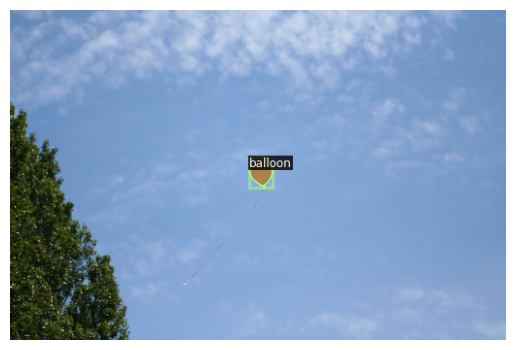

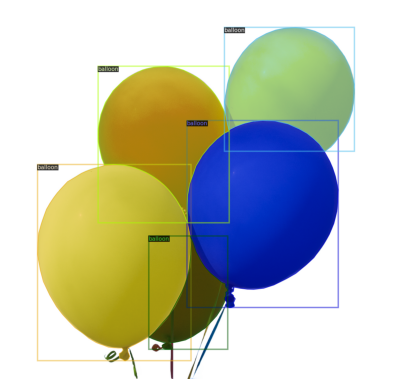

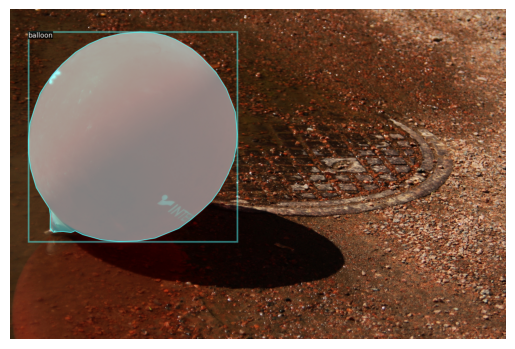

In [3]:
dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    # Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
    img_rgb = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')  # Turn off axis ticks and labels
    plt.show()

In [6]:
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
#cfg.DATASETS.VAL = ("balloon_val",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/21 15:00:40 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[10/21 15:00:40 d2.engine.train_loop]: Starting training from iteration 0
[10/21 15:03:30 d2.utils.events]:  eta: 0:40:04  iter: 19  total_loss: 2.055  loss_cls: 0.7048  loss_box_reg: 0.5619  loss_mask: 0.6967  loss_rpn_cls: 0.02869  loss_rpn_loc: 0.00407    time: 8.4113  last_time: 12.6680  data_time: 0.1200  last_data_time: 0.0061   lr: 1.6068e-05  
[10/21 15:07:57 d2.utils.events]:  eta: 0:42:50  iter: 39  total_loss: 1.887  loss_cls: 0.5788  loss_box_reg: 0.6719  loss_mask: 0.6206  loss_rpn_cls: 0.02948  loss_rpn_loc: 0.00891    time: 10.9992  last_time: 7.8946  data_time: 0.0081  last_data_time: 0.0035   lr: 3.2718e-05  
[10/21 15:11:43 d2.utils.events]:  eta: 0:39:04  iter: 59  total_loss: 1.591  loss_cls: 0.4594  loss_box_reg: 0.5818  loss_mask: 0.4758  loss_rpn_cls: 0.04607  loss_rpn_loc: 0.01261    time: 11.0989  last_time: 8.9745  data_time: 0.0056  last_data_time: 0.0025   lr: 4.9367e-05  
[10/21 15:15:21 d2.utils.events]:  eta: 0:37:04  iter: 79  total_loss: 1.356  loss_cls

In [7]:
%load_ext tensorboard
%tensorboard --logdir output

Reusing TensorBoard on port 6006 (pid 16112), started 17:46:08 ago. (Use '!kill 16112' to kill it.)

In [8]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[10/21 16:07:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/Users/stefano_ruggiero/miniconda3/envs/detectron2/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.l

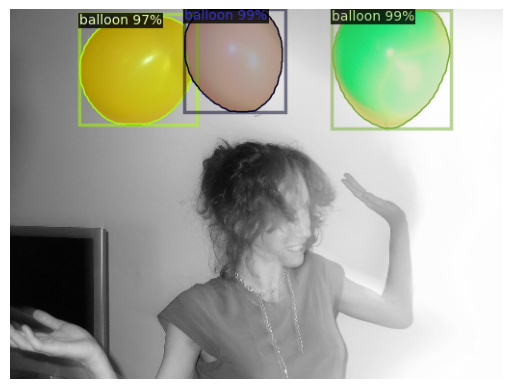

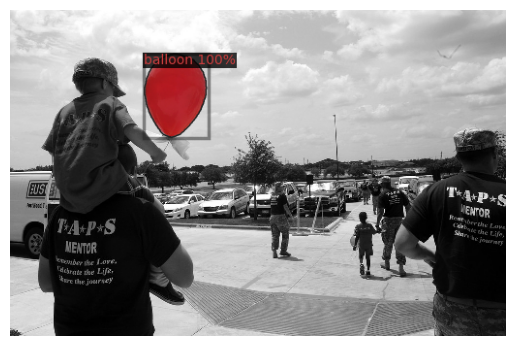

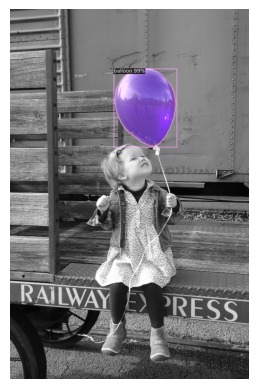

In [9]:
from detectron2.utils.visualizer import ColorMode
import matplotlib.pyplot as plt
dataset_dicts = DatasetCatalog.get("balloon_val")

# Loop attraverso 3 immagini casuali del dataset di convalida
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata,  # Usa i metadati COCO
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    # Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
    img_rgb = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')  # Turn off axis ticks and labels
    plt.show()

In [10]:
evaluator = COCOEvaluator("balloon_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "balloon_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[10/21 16:07:43 d2.evaluation.coco_evaluation]: Trying to convert 'balloon_val' to COCO format ...
[10/21 16:07:43 d2.data.datasets.coco]: Converting annotations of dataset 'balloon_val' to COCO format ...)
[10/21 16:07:43 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[10/21 16:07:43 d2.data.datasets.coco]: Conversion finished, #images: 13, #annotations: 50
[10/21 16:07:43 d2.data.datasets.coco]: Caching COCO format annotations at './output/balloon_val_coco_format.json' ...
[10/21 16:07:43 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  balloon   | 50           |
|            |              |
[10/21 16:07:43 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/21 16:07:43 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[1